In [1]:
# TODO: Try diagonal and uniform correlations (totally uncorrelated and correlated) (think about the circle)
# TODO: Make sure we're finding global minimum
# TODO: With and without portfolio
# TODO: Emphasize hyperfactors
# TODO: Paramters - factors, dates, correlation

# TODO: Remove first principal component... make it beta neutral

In [2]:
from typing import Optional, List
from importlib import reload
import pandas as pd

from data import get_yf_data, get_factor_master, get_portfolios, get_factor_data
from stats import get_volatility_set, get_correlation_set
from util import xr_pct_change, safe_reindex

from corr_mds import *

In [3]:
from importlib import reload
import corr_mds
reload(corr_mds)
from corr_mds import *

In [4]:
# def get_factor_data_port(halflifes: Optional[List[int]] = None) -> xr.Dataset:
# if halflifes == None:
#     halflifes = [21, 63, 126, 252, 512]

factor_master = get_factor_master(sheet_name='read')
asset_list = factor_master.loc[factor_master['composite'] == 0].index.to_list()
portfolios = get_portfolios().pipe(safe_reindex, factor_master).fillna(0).loc[asset_list]


In [5]:
ds = xr.Dataset()
ds['ohlcv'] = get_yf_data(asset_list) #.to_dataset(name='ohlcv')
ds['cret']  = ds['ohlcv'].sel(ohlcv_type='adj close')
# ds['ret']   = xr_pct_change(ds['cret'], 'date')

asset_ret = xr_pct_change(ds['cret'], 'date').to_pandas()
portfolios_ret = asset_ret @ portfolios


[*********************100%%**********************]  55 of 55 completed


In [6]:
halflifes = [21, 63, 126]

factor_data2 = xr.Dataset()
factor_data2['ret'] = pd.concat([asset_ret, portfolios_ret], axis=1).rename_axis(columns='asset')
# factor_data2['ret'] = (pd.concat([asset_ret['MWTIX'], portfolios_ret, asset_ret.drop(columns=['MWTIX'])], axis=1).rename_axis(columns='asset'))

factor_data2['vol']   = get_volatility_set(factor_data2['ret'], halflifes)
factor_data2['corr']  = get_correlation_set(factor_data2['ret'], halflifes)
factor_data2['cret']  = factor_data2['ret'].cumsum(dim='date')

factor_data2['asset'].attrs = factor_master.T.to_dict()


In [7]:
# mds_ts = (mds_ts_df(factor_data2.corr, transformation='rotate_initial', start_date='2024')
#             .reset_index()
#             .join(factor_master, on='asset')
#             .assign(date = lambda df: df['date'].astype(str))
#             # .assign(size = lambda df: df['hyper_factor'].mul(1).add(.5).astype('float'))
#             .assign(size = lambda df: df['hyper_factor'].apply(lambda x: 10 if x == 1 else 3).astype('float'))
#             .replace('MWTIX', 'TCW')
#             )


In [8]:
from importlib import reload
import corr_mds
reload(corr_mds)
from corr_mds import *

def run_mds(corr, transformation, dates, start_date, tick_range, drop_composites=True, drop_trump=False, **kwargs):
    # TODO: Pass in a list of dates or take all dates from the dataarray
    t0, t1, t2 = dates
    
    # t0 = '2024-11-18'
    # t1 = '2024-10-18'
    # # t1 = '2024-11-05'
    # t2 = '2024-08-14'

    # (t0, t1, t2) = factor_data2.date.values[[-1, -21-1, -63-1]]

    transformation_type = {None:             'No rotation', 
                           'rotate':         'Rotate SPY to x-axis each day', 
                           'normalize':      'SPY transformed to (1, 0)',
                           'rotate_initial': '' #'Rotate SPY to x-axis today'
                           }

    mds_ts = (mds_ts_df(corr, transformation=transformation, start_date=start_date, **kwargs)
                .reset_index()
                .join(factor_master, on='asset')
                .assign(date = lambda df: df['date'].astype(str))
                # .assign(size = lambda df: df['hyper_factor'].mul(1).add(.5).astype('float'))
                .assign(size = lambda df: df['hyper_factor'].apply(lambda x: 10 if x == 1 else 3).astype('float'))
                .replace('MWTIX', 'TCW')
                )
    
    if drop_composites:
        mds_ts = mds_ts.query('composite == 0')
        
    if drop_trump:
        mds_ts = mds_ts.query('asset != "TRUMP"')
        
    mds_latest = mds_ts[mds_ts['date'] == t0].drop(columns='date')
    fig = draw_mds_ts(mds_latest, tick_range=tick_range)
    fig = add_whiskers(fig, mds_ts, t0, t1)
    fig = add_whiskers(fig, mds_ts, t1, t2)
    fig.update_layout(legend_title_text=None, title=f'{transformation_type[transformation]}')
    
    
    def get_trace_color(trace, legendgroup):
        return trace.marker.color if trace.legendgroup in ['Theme', 'Portfolio'] else 'lightgray'
    
    def update_text_color(trace, asset_class_list):
        trace.update(textfont_color = (trace.marker.color 
                                       if trace.legendgroup in asset_class_list 
                                       else 'lightgray'))
    
    asset_class_list = ['Theme', 'Portfolio']
    fig.for_each_trace(lambda t: t.update(textfont_color = get_trace_color(t, asset_class_list))) #update_text_color(t, asset_class_list)) # t.legendgroup
    
    # r = sqrt(2)/2
    # r = 0.8
    # fig.add_shape(
    #     type="circle",
    #     xref="x", yref="y",
    #     x0=-r, y0=-r, x1=r, y1=r,
    #     line_color='lightgray', line_width=.5,
    #     )
    
    return fig

# mds_previous = mds_ts[mds_ts['date'] == t1].drop(columns='date')
# fig_previous = (draw_mds_ts(mds_previous, tick_range=1.5)
#                 .update_traces(text=None,  opacity=0.3) # marker_size=5,
#                 .update_layout(showlegend=False))
# for trace in fig_previous.data:
#     trace.showlegend = False
#     fig.add_trace(trace)

# for trace in fig.data:
#     if trace.mode == 'lines':
#         for marker_trace in fig.data:
#             if marker_trace.mode == 'markers+text' and marker_trace.name == trace.legendgroup:
#                 trace.update(line=dict(color=marker_trace.marker.color))
#                 break


In [9]:
# color_dict = {a: b for a, b in zip(factor_master.asset_class.unique(), color_sequence)}
# color_dict['Portfolio'] = 'black'
# color_dict['Composite'] = 'darkred'
# color_dict


In [10]:
import plotly.io as pio
color_sequence = pio.templates['plotly_white']['layout']['colorway']
color_sequence
# pio.templates

('#636efa',
 '#EF553B',
 '#00cc96',
 '#ab63fa',
 '#FFA15A',
 '#19d3f3',
 '#FF6692',
 '#B6E880',
 '#FF97FF',
 '#FECB52')

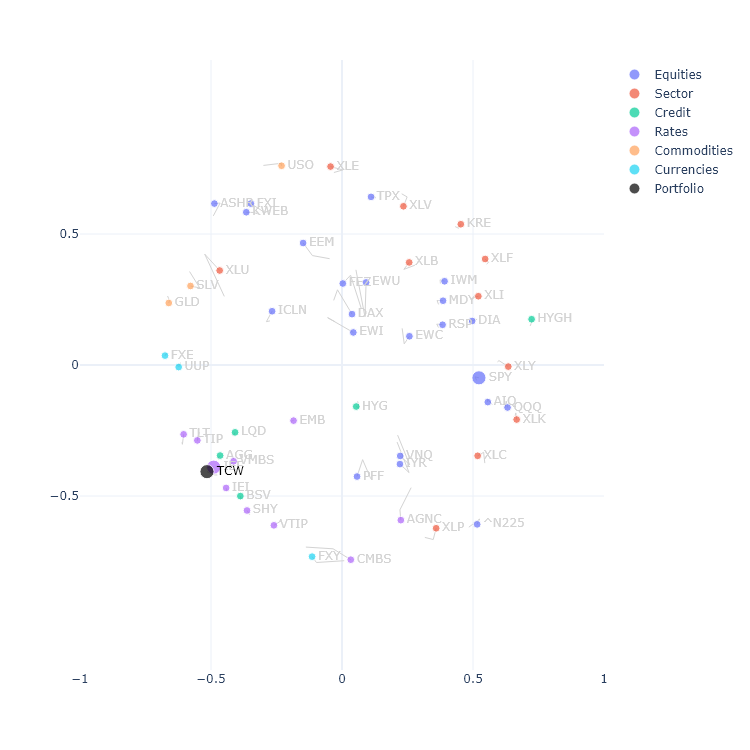

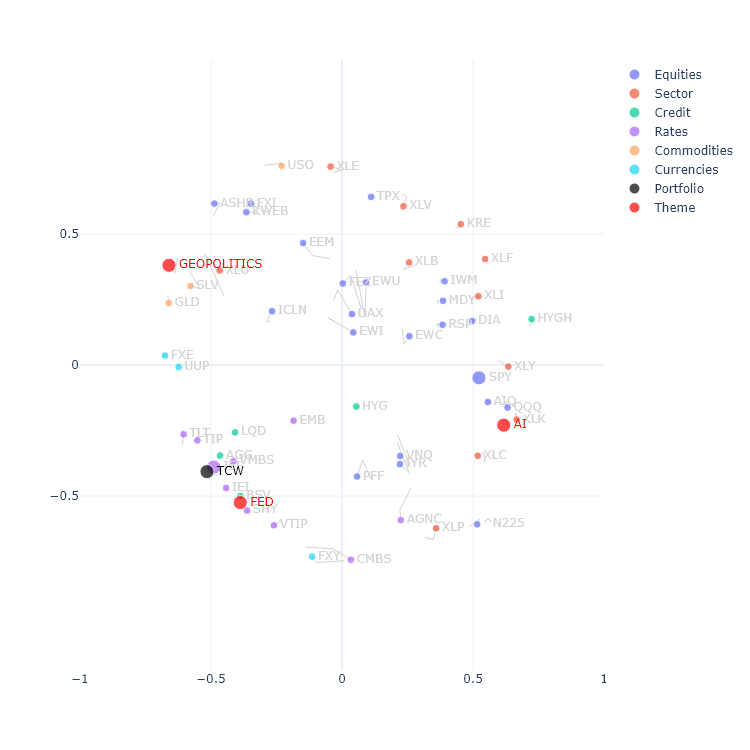

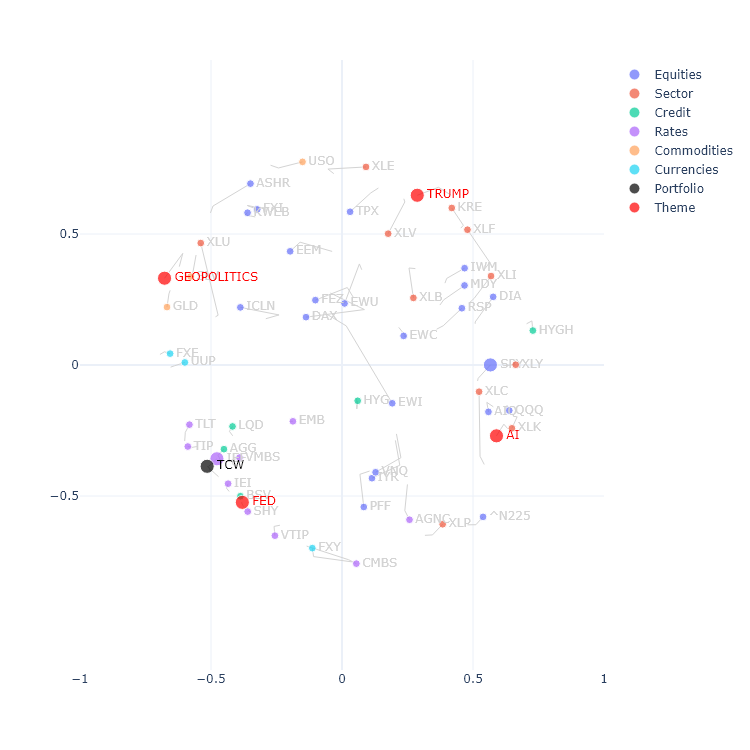

In [12]:
from importlib import reload
import corr_mds
reload(corr_mds)
from corr_mds import *

# TODO: Do the args work?!

args = {'random_state': 42, 
        'n_init': 100}

dates_t1 = ['2024-11-20', '2024-10-18', '2024-08-16']
dates_t0 = ['2024-10-31', '2024-09-30', '2024-08-30']

# TCW as of 2024-10-31
# TCW + 3 themes as of 2024-10-31
# TCW + 3 themes + trump as of 2024-11-18

fig = (run_mds(factor_data2.corr, 
               transformation='rotate_initial', 
               dates=dates_t0,
               start_date='2024', 
               tick_range=1,
               drop_composites=True,
               drop_trump=True,
               **args)
    #    .update_layout(title=f"random_state={args['random_state']}, n_init={args['n_init']}")
       )
fig.show(renderer='png')
fig.write_image('corr_tcw.png')

fig = (run_mds(factor_data2.corr, 
               transformation='rotate_initial', 
               dates=dates_t0,
               start_date='2024', 
               tick_range=1,
               drop_composites=False,
               drop_trump=True,
               **args)
    #    .update_layout(title=f"random_state={args['random_state']}, n_init={args['n_init']}")
       )
fig.show(renderer='png')
fig.write_image('corr_theme.png')

fig = (run_mds(factor_data2.corr, 
               transformation='rotate_initial', 
               dates=dates_t1,
               start_date='2024', 
               tick_range=1,
               drop_composites=False,
               drop_trump=False,
               **args)
    #    .update_layout(title=f"random_state={args['random_state']}, n_init={args['n_init']}")
       )
fig.show(renderer='png')
fig.write_image('corr_trump.png')




In [ ]:
# fig.for_each_trace(lambda t: t.update(textfont_color = t.marker.color if t.marker.size == 10 else 'lightgray'))
# fig.show(renderer='png')

In [ ]:
fig.for_each_trace(lambda t: print(t.marker.size if t.marker.size is not None else None))

In [ ]:
fig.for_each_trace(lambda t: t.update(textfont_color = (t.marker.color if t.legendgroup in ['Theme', 'Portfolio'] else 'lightgray'))) # t.legendgroup
# fig.for_each_trace(lambda t: print(t.legendgroup, t.marker.color)) # t.legendgroup
fig.update_layout(title='')
fig.show(renderer='png')


In [ ]:
# factor_data2.corr.sel(date='2024-11-18', corr_type=63).to_pandas().style

In [ ]:
# reload(corr_mds)
# run_mds(factor_data2.corr, transformation=None, start_date='2004', tick_range='auto').show(renderer='png')
# run_mds(factor_data2.corr, transformation='rotate', start_date='2004', tick_range='auto').show(renderer='png')
# run_mds(factor_data2.corr, transformation='rotate_initial', start_date='2004', tick_range='auto').show(renderer='png')
# # run_mds(factor_data2.corr, transformation='normalize', start_date='2004', tick_range='auto').show(renderer='png')
# # run_mds(factor_data2.corr, transformation='rotate_list', start_date='2004', tick_range='auto').show(renderer='png')
# # run_mds(factor_data2.corr, transformation='normalize', start_date='2004', tick_range=1).show(renderer='png')
# # fig.show(renderer='png')


# Market Feedback

In [ ]:
factor_data2.cret.sel(asset='ICLN').plot()

In [ ]:
xr_pct_change(factor_data2.cret.sel(asset='ICLN'), dim='date', periods=21)

factor_data2.cret.sel(asset='ICLN', date=slice('2024-9-14', None)).plot()

In [ ]:
def accumulate(da_ret, t0, t1, dim='date'):
    # return (da_ret.sel(date=slice(t0, t1))+1).cumprod('date')-1
    return (da_ret.sel({dim: slice(t0, t1)})+1).cumprod(dim) #-1

t0 = '2024-10-14'
t1 = '2024-11-14'

accumulate(factor_data2.ret, t0, t1).to_pandas()


# ((ds1.ret+1).cumprod('date')-1).to_pandas().sort_index(ascending=False).to_clipboard()

In [ ]:
from util import xr_pct_change

date_latest = pd.to_datetime(factor_data2.date.max().item())
date_latest = '2024-11-14'
vol_type = 63

vol = factor_data2.vol.sel(date=date_latest, vol_type=vol_type).to_series()
# ret = factor_data.ret.sel(date=date_latest).to_series()
ret = xr_pct_change(factor_data2.cret, dim='date', periods=21).sel(date=date_latest).to_series().rename('ret').mul(100)


df = pd.concat([ret, vol, factor_master], axis=1).reset_index()

fig_format = {'template': 'plotly_white', 'height': 750, 'width': 750}
fig = (px.scatter(df, x='vol', y='ret', color='asset_class', text='index', **fig_format)
       .update_traces(textposition='middle right', 
                      textfont_color='lightgray')
       .update_layout(# xaxis_title=None,
                      # yaxis_title=None,
                      # xaxis_showticklabels=False,
                      # yaxis_showticklabels=False,
                      # xaxis_showgrid=False,
                      # yaxis_showgrid=False,
                      xaxis_showline=False,
                      yaxis_showline=False,
                      legend_title_text=None,
                      )
       )

# fig.show(renderer='png')
fig.show()

In [ ]:
factor_data2['cret'].to_pandas()['SPY'].plot()

In [ ]:

# ds1 = factor_data2.sel(asset='SPY')
# ds1.ret.to_pandas().sort_index(ascending=False).to_clipboard()
# ((ds1.ret+1).cumprod('date')-1).to_pandas().sort_index(ascending=False).to_clipboard()
# xr_pct_change(((ds1.ret+1).cumprod('date')-1), dim='date', periods=1).to_pandas().sort_index(ascending=False).to_clipboard()

# # xr_pct_change(((factor_data2.ret.sel(asset='SPY')+1).cumprod('date')-1), dim='date', periods=1).to_pandas().to_clipboard()